In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

import os
import logging
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from notebooks import utils, ts_plotter

logging.basicConfig(format='%(asctime)s | %(name)s | %(message)s',
    level=logging.INFO, datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger('INTM')

In [11]:
data = pd.read_csv('/home/alex/Projects/earthquake-prediction/data/train.csv')
#data.set_index('segment_id', inplace=True)
data = data.replace([np.inf, -np.inf], np.nan)
data.fillna(method='bfill', inplace=True)
data.fillna(value=0, inplace=True)
data.head()

,Hann_window_mean_150,Hann_window_mean_1500,Hann_window_mean_15000,Hann_window_mean_50,Hilbert_mean,abs_max,abs_max_roll_mean_10,abs_max_roll_mean_100,abs_max_roll_mean_1000,abs_max_roll_mean_10000,...,std_roll_std_500,sum,target,time_rev_asym_stat_1,time_rev_asym_stat_10,time_rev_asym_stat_100,time_rev_asym_stat_5,time_rev_asym_stat_50,trend,zero_crossing_rate
0,4.88333,4.87666,4.80908,4.88386,7.02703,104,68.5,10.04,5.629,5.2457,...,2.92102,732617,1.4308,0.25926,5.33570,-5.64063,3.41103,-0.59575,-0.0,0.07384
1,4.72505,4.71842,4.65315,4.72553,7.38038,181,145.1,16.67,5.667,4.9398,...,4.67924,708865,1.3915,-6.40173,-6.87905,-1.10509,4.08906,6.47195,0.0,0.07986
2,4.90551,4.89892,4.83220,4.90604,8.01693,140,94.8,12.38,5.957,5.2859,...,4.67551,735959,1.3532,-1.56699,-6.52812,7.87834,3.75582,-10.55177,0.0,0.07945
3,4.90143,4.89464,4.82767,4.90198,7.60685,199,136.6,18.26,5.858,5.2169,...,5.05452,735336,1.3138,-1.07589,-0.60859,1.17383,-14.63104,8.37250,0.0,0.07453
4,4.90812,4.90185,4.83630,4.90853,7.89540,145,107.6,14.41,6.078,5.2651,...,5.38091,736308,1.2744,-4.24312,6.89355,3.51326,1.06582,-0.94268,-0.0,0.07250


In [12]:
features = [c for c in data.columns if c not in ['target', 'seg_id']]

In [22]:
best_features = utils.print_features_imp(data[features], data['target'], logger, permutation=True, min_imp=0.015)
best_features

2019-06-03 15:37:04 | INTM |   Imp | Feature
2019-06-03 15:37:04 | INTM |   66% | all_rollstd100_q5
2019-06-03 15:37:04 | INTM |   37% | all_mfcc15_avg
2019-06-03 15:37:04 | INTM |   32% | all_mfcc4_avg
2019-06-03 15:37:04 | INTM |   24% | all_mfcc5_avg
2019-06-03 15:37:04 | INTM |   19% | all_rollstd1000_q5
2019-06-03 15:37:04 | INTM |   12% | all_mfcc15_q5
2019-06-03 15:37:04 | INTM |   11% | all_mfcc4_q5
2019-06-03 15:37:04 | INTM |   10% | all_rollstd10_q5
2019-06-03 15:37:04 | INTM |   10% | all_mfcc5_q5
2019-06-03 15:37:04 | INTM |    8% | all_rollstd1000_avg
2019-06-03 15:37:04 | INTM |    7% | all_rollstd100_avg
2019-06-03 15:37:04 | INTM |    7% | all_rollstd10_avg


['all_rollstd100_q5',
 'all_mfcc15_avg',
 'all_mfcc4_avg',
 'all_mfcc5_avg',
 'all_rollstd1000_q5',
 'all_mfcc15_q5',
 'all_mfcc4_q5',
 'all_rollstd10_q5',
 'all_mfcc5_q5',
 'all_rollstd1000_avg',
 'all_rollstd100_avg',
 'all_rollstd10_avg']

In [45]:
data['target_int'] = data['target'].round().astype(int)
model = RandomForestClassifier(n_estimators=100, max_features=1, min_samples_leaf=10)
#model = KNeighborsClassifier(n_neighbors=10)
model.fit(data[features], data['target_int'])
data['y_hat_int'] = model.predict(data[features])

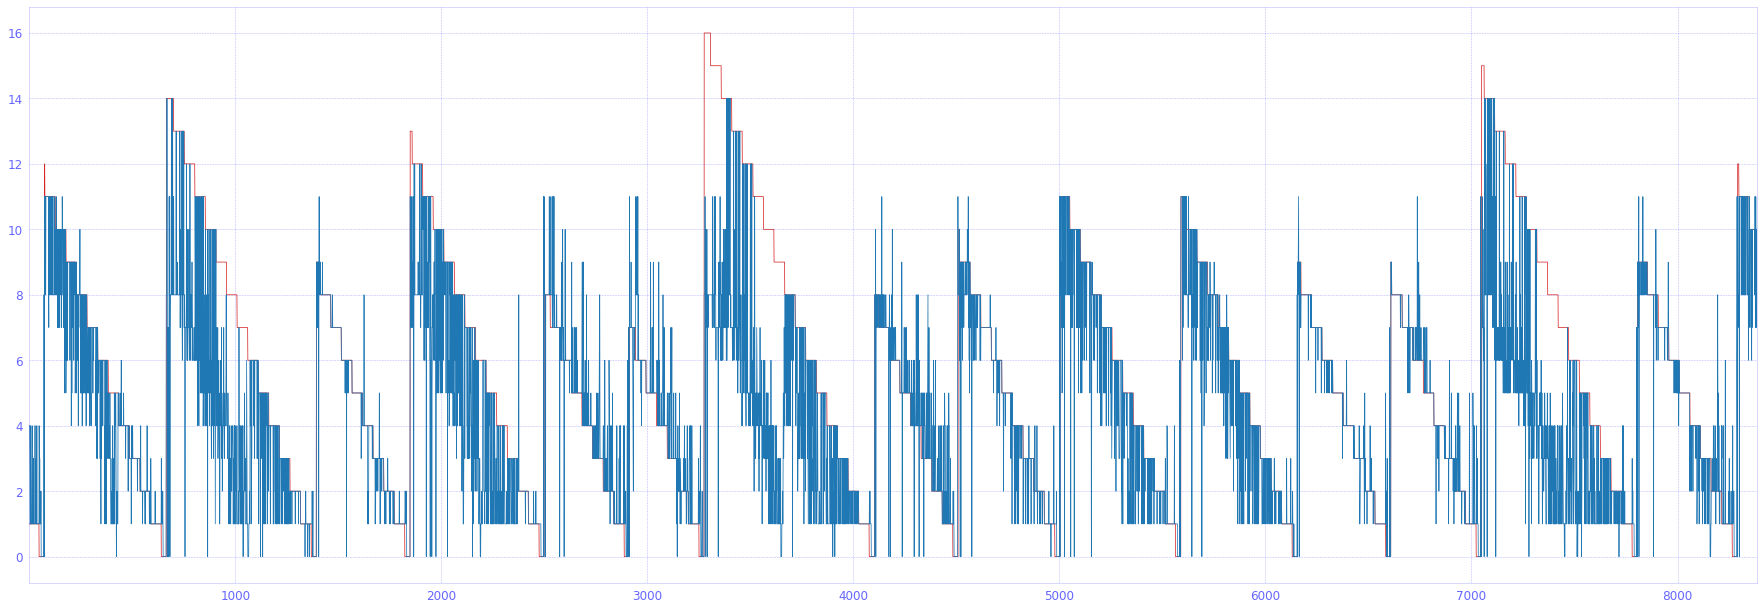

In [29]:
plotter = ts_plotter.TimeSeriesPlot(fig_size=(30, 10), n_rows=1, n_cols=1, type='line', show=False)
plotter.plot(data, y_vars=['target_int', 'y_hat_int'], x_var='seg_id', xlim=[1, len(data)])

In [32]:
train = data.query('abs(target_int - y_hat_int) < 5')
len(train)

7250

In [8]:
ga_features = [
    'mfcc_15_avg', 'std_roll_mean_100', 'ffti_time_rev_asym_stat_10', 'mfcc_4_avg', 
    'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000', 
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100', 
    'fftr_percentile_roll_std_30_window_100', 'ffti_count_big_50000_threshold_5', 
    'percentile_roll_std_25_window_1000', 'percentile_roll_std_20_window_100', 
    'percentile_roll_std_40_window_100', 'fftr_percentile_roll_std_1_window_50', 
    'percentile_roll_std_40_window_1000']

utils.tune_random_forest(data[ga_features], data['target'], logger, n_estimators=[100], n_splits=5)

2019-06-03 16:37:54 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-06-03 16:38:05 | INTM |     100 |    auto |       1 |    0.00 |   2.072


In [9]:
ga_features_2 = [
    'mfcc_15_avg', 'std_roll_mean_100', 'ffti_time_rev_asym_stat_10', 'mfcc_4_avg',
    'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000',
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100',
    'fftr_percentile_roll_std_30_window_100', 'ffti_max_roll_std_50', 'fftr_std_roll_mean_10000',
    'fftr_spkt_welch_density_10', 'percentile_roll_std_40_window_100',
    'fftr_percentile_roll_std_1_window_50', 'percentile_roll_std_40_window_1000']

utils.tune_random_forest(data[ga_features_2], data['target'], logger, n_estimators=[100], n_splits=5)

2019-06-03 16:38:05 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-06-03 16:38:16 | INTM |     100 |    auto |       1 |    0.00 |   2.066


In [10]:
ga_features_3 = [
    'mfcc_15_avg', 'std_roll_mean_100', 'ffti_time_rev_asym_stat_10', 'mfcc_4_avg',
    'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000',
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100',
    'fftr_percentile_roll_std_30_window_100', 'percentile_roll_std_30_window_50', 'fftr_std_roll_mean_10000',
    'fftr_spkt_welch_density_10', 'ffti_classic_sta_lta3_mean',
    'fftr_percentile_roll_std_1_window_50', 'percentile_roll_std_40_window_1000']

utils.tune_random_forest(data[ga_features_3], data['target'], logger, n_estimators=[100], n_splits=5)

2019-06-03 16:38:16 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-06-03 16:38:26 | INTM |     100 |    auto |       1 |    0.00 |   2.062


In [11]:
ga_features_4 = [
    'mfcc_15_avg', 'std_roll_mean_100', 'ffti_time_rev_asym_stat_10', 'mfcc_4_avg',
    'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000',
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100',
    'fftr_percentile_roll_std_30_window_100', 'percentile_roll_std_30_window_50',
    'fftr_num_peaks_100', 'ffti_mfcc_7_avg', 'ffti_classic_sta_lta3_mean',
    'fftr_percentile_roll_std_1_window_50', 'percentile_roll_std_40_window_1000']

utils.tune_random_forest(data[ga_features_4], data['target'], logger, n_estimators=[100], n_splits=5)

In [16]:
ga_features_5 = [
    'mfcc_15_avg', 'std_roll_mean_100', 'ffti_percentile_roll_std_5_window_10000', 'mfcc_4_avg',
    'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000', 
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100', 
    'fftr_percentile_roll_std_30_window_100', 'percentile_roll_std_30_window_50',
    'fftr_num_peaks_100', 'ffti_Hann_window_mean_1500', 'fftr_percentile_roll_std_30_window_50',
    'fftr_percentile_roll_std_1_window_50', 'percentile_roll_std_40_window_1000'
]

utils.tune_random_forest(data[ga_features_5], data['target'], logger, n_estimators=[100], n_splits=5)

2019-06-04 11:10:42 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-06-04 11:10:52 | INTM |     100 |    auto |       1 |    0.00 |   2.054


In [15]:
ga_features_6 = [    
    'mfcc_15_avg', 'ffti_av_change_rate_roll_mean_500', 'ffti_time_rev_asym_stat_10', 
    'mfcc_4_avg', 'fftr_percentile_roll_std_80_window_10000', 'percentile_roll_std_20_window_1000',
    'ffti_exp_Moving_average_30000_mean', 'fftr_time_rev_asym_stat_100', 
    'fftr_percentile_roll_std_30_window_100', 'percentile_roll_std_30_window_50',
    'fftr_num_peaks_100', 'ffti_mfcc_7_avg', 'ffti_classic_sta_lta3_mean',
    'fftr_percentile_roll_std_1_window_50', 'percentile_roll_std_40_window_1000'
]

utils.tune_random_forest(data[ga_features_6], data['target'], logger, n_estimators=[100], n_splits=5)

2019-06-04 11:10:28 | INTM |   n_est | n_feats | n_leafs |     MSE |     MAE
2019-06-04 11:10:38 | INTM |     100 |    auto |       1 |    0.00 |   2.054


In [8]:
utils.tune_catboost(data[ga_features_5], data['target'], n_splits=5)

2019-06-04 09:29:28 | INTM | iter | depth | rand | rate |   L2 | temp |    LF |     MAE
2019-06-04 09:30:12 | INTM |   10 |     4 |  1.0 | 0.03 |  3.0 |  1.0 |  RMSE |   2.059


In [32]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.33, random_state=0)

In [ ]:
model = RandomForestRegressor(n_estimators=100)
for k in range(2, 9):
    train, test = train_test_split(data, test_size=0.33, random_state=0)
    train = train.query('abs(target_int - y_hat_int) < @k').reset_index()
    model.fit(train[features], train['target'])
    test['y_hat'] = model.predict(test[features])
    print('k={}: mae={}'.format(k, np.mean(np.abs(test['target'].values - test['y_hat'].values))))

In [56]:
model = CatBoostRegressor(verbose=False)
model.fit(data[best_features], data['target'])
res=pd.DataFrame()
res['seg_id'] = data['seg_id']
res['y']=data['target']
res['y_hat']=model.predict(data[best_features])

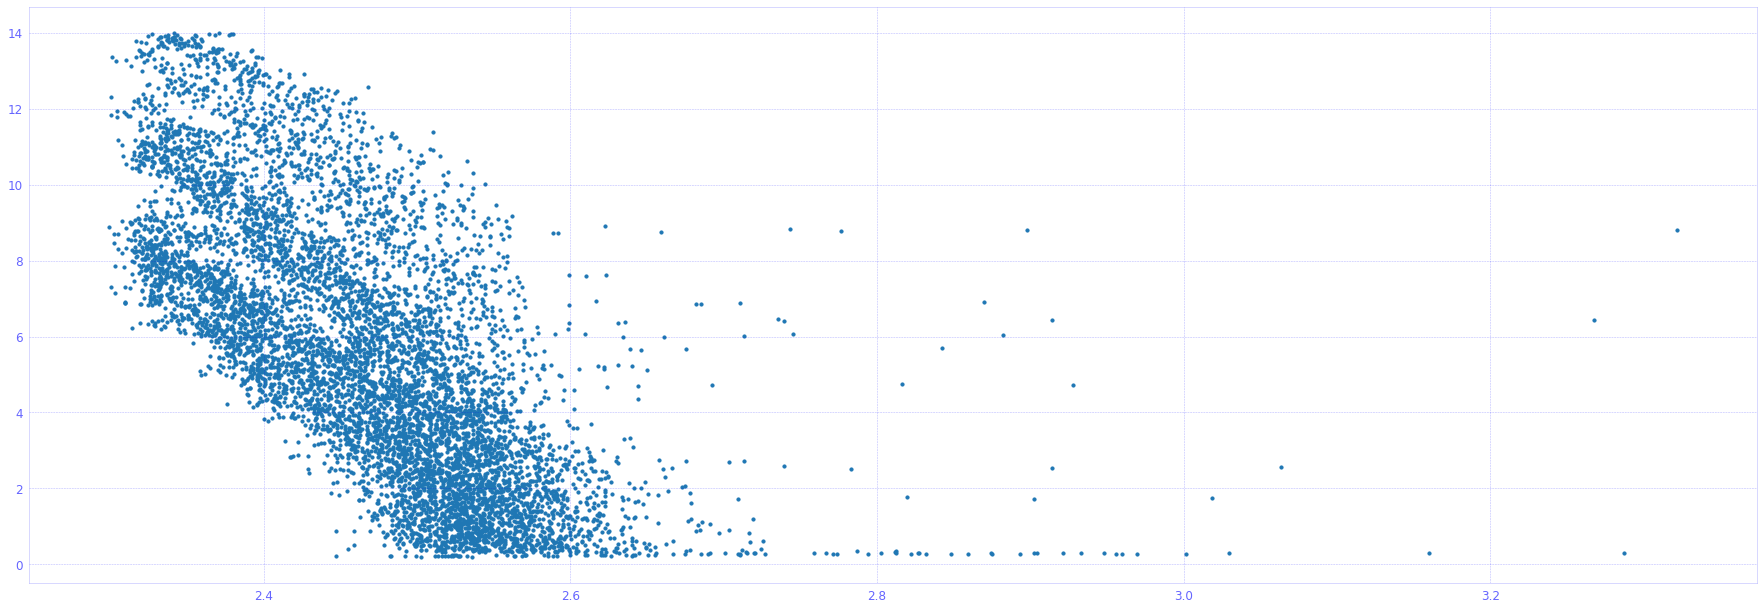

In [57]:
plotter = ts_plotter.TimeSeriesPlot(fig_size=(30, 10), n_rows=1, n_cols=1, type='scatter', show=False)
plotter.plot(data, y_vars=['target'], x_var='all_rollstd100_q5')

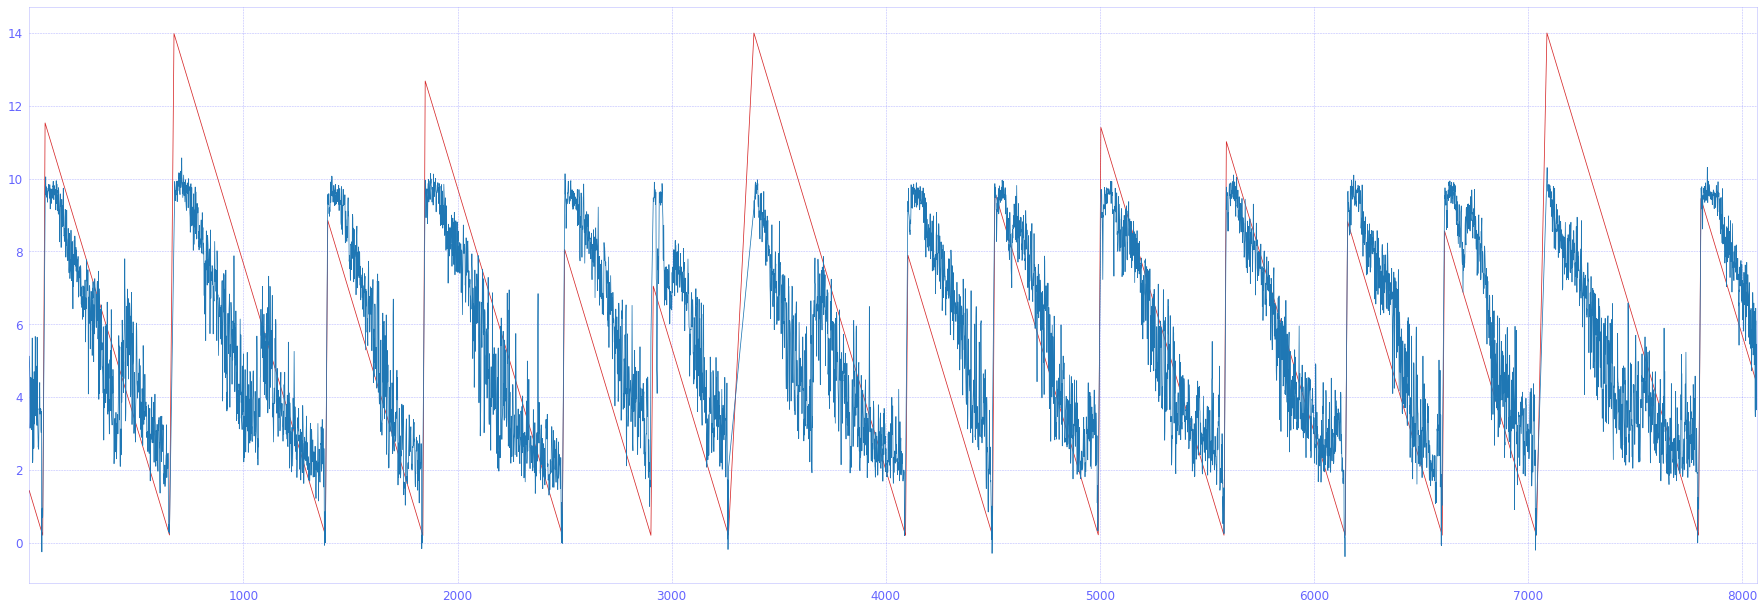

In [58]:
plotter = ts_plotter.TimeSeriesPlot(fig_size=(30, 10), n_rows=1, n_cols=1, type='line', show=False)
plotter.plot(res, y_vars=['y', 'y_hat'], x_var='seg_id', xlim=[1, len(data)])

In [59]:
np.mean(np.abs(res['y'].values - res['y_hat'].values))

1.7700093311025082

In [4]:
d=pd.read_hdf('/home/alex/Projects/kaggle-eathquake/data/train_int16float32.hdf', start=4e6, stop=6e6)
x = d['acoustic_data'].values.astype('float32')

In [18]:
mfcc = librosa.feature.mfcc(y=x)

In [33]:
spec_c = librosa.feature.spectral_centroid(y=x)
spec_bw = librosa.feature.spectral_bandwidth(y=x)

In [47]:
S = np.abs(librosa.stft(x))
contrast = librosa.feature.spectral_contrast(S=S)

In [30]:
flatness = librosa.feature.spectral_flatness(y=x)

In [52]:
rolloff = librosa.feature.spectral_rolloff(y=x)

In [6]:
rate = librosa.feature.zero_crossing_rate(y=x)

In [92]:
oenv = librosa.onset.onset_strength(x)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, win_length=150)

In [14]:
S = np.abs(librosa.stft(x))
comps, acts = librosa.decompose.decompose(S, n_components=8)

In [8]:
best_features

['mfcc_15_avg',
 'mfcc_5_avg',
 'percentile_roll_std_5_window_50',
 'mfcc_4_avg',
 'percentile_roll_std_10_window_100',
 'percentile_roll_std_20_window_1000',
 'percentile_roll_std_20_window_500',
 'percentile_roll_std_10_window_50',
 'percentile_roll_std_25_window_500',
 'percentile_roll_std_25_window_100',
 'percentile_roll_std_25_window_1000']

In [213]:
lowcut=500
highcut=1250
order=5
fs=7000
d=pd.read_hdf('/home/alex/Projects/kaggle-eathquake/data/train_int16float32.hdf', 
              start=4700000, stop=4900000)
x = d['acoustic_data'].values.astype('float32')
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
b, a = signal.butter(order, [low, high], btype='band')
y = signal.lfilter(b, a, x)
mfcc = librosa.feature.mfcc(y=y)
mfccx = librosa.feature.mfcc(y=x)

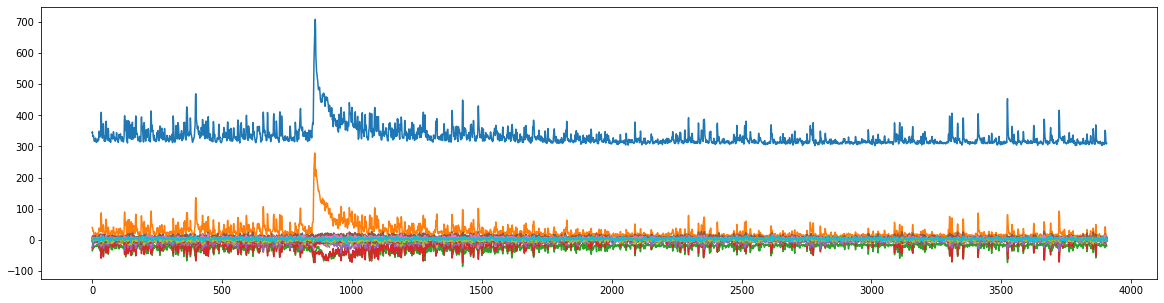

In [19]:
plt.figure(figsize=(20,5))
for i in range(len(mfcc)):
    plt.plot(mfcc[i])
#plt.plot(y)
plt.show()

In [7]:
len(rate)

1

In [95]:
150000/512

292.96875

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymssa import MSSA
d=pd.read_hdf('/home/alex/Projects/kaggle-eathquake/data/train_int16float32.hdf', start=0, stop=20000)
x = d['acoustic_data'].values.astype('float32')
x -= np.mean(x)
mssa = MSSA(n_components=15, window_size=64, verbose=True)
mssa.fit(x)

Constructing trajectory matrix
Trajectory matrix shape: (64, 19937)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(d['acoustic_data'].values)
plt.show()
for cid in range(11):
    fig, ax = plt.subplots(figsize=(20, 7))
    ax.plot(mssa.components_[0, :, cid])
    plt.show()

In [10]:
len(mssa.components_[0, :, 1])

1500

In [25]:
store.close()

In [19]:
t=['x', 'xx', 'xxx']
'_'.join([x for x in t])

'x_xx_xxx'

In [3]:
[1, [1,2], 3]

[1, [1, 2], 3]

In [10]:
import numpy as np
x = x.astype('float32') 
x -= np.mean(x)

In [11]:
np.mean(x)

2.5482177e-07

In [12]:
len(x)

20000

In [13]:
len(x[:1000])

1000

In [15]:
c='last1000_sas_sasdasd'
c[:8]

'last1000'

In [50]:
best_features

['all_mfcc15_avg',
 'all_mfcc5_avg',
 'all_mfcc0_avg',
 'all_mfcc2_avg',
 'all_centr_avg',
 'all_centr_q95',
 'all_mfcc4_avg',
 'all_zrate_avg',
 'all_mfcc1_avg']

In [91]:
s=pd.Series(x)
s

0         12.0
1          6.0
2          8.0
3          5.0
4          8.0
5          8.0
6          9.0
7          7.0
8         -5.0
9          3.0
10         5.0
11         2.0
12         2.0
13         3.0
14        -1.0
15         5.0
16         6.0
17         4.0
18         3.0
19         5.0
20         4.0
21         2.0
22         6.0
23         7.0
24         7.0
25         8.0
26        14.0
27         9.0
28         4.0
29         7.0
          ... 
149970     6.0
149971     7.0
149972     9.0
149973     5.0
149974     5.0
149975     5.0
149976     7.0
149977     5.0
149978    11.0
149979    10.0
149980     8.0
149981     7.0
149982     4.0
149983     3.0
149984     7.0
149985     7.0
149986    10.0
149987    10.0
149988     5.0
149989     6.0
149990    13.0
149991     7.0
149992     4.0
149993     7.0
149994    -2.0
149995     1.0
149996     6.0
149997     6.0
149998     2.0
149999     0.0
Length: 150000, dtype: float32

In [130]:
features

['all_centr_avg',
 'all_bw_avg',
 'all_contr_avg',
 'all_flat_avg',
 'all_rlf_avg',
 'all_zrate_avg',
 'all_mfcc0_avg',
 'all_mfcc1_avg',
 'all_mfcc2_avg',
 'all_mfcc3_avg',
 'all_mfcc4_avg',
 'all_mfcc5_avg',
 'all_mfcc6_avg',
 'all_mfcc7_avg',
 'all_mfcc8_avg',
 'all_mfcc9_avg',
 'all_mfcc10_avg',
 'all_mfcc11_avg',
 'all_mfcc12_avg',
 'all_mfcc13_avg',
 'all_mfcc14_avg',
 'all_mfcc15_avg',
 'all_mfcc16_avg',
 'all_mfcc17_avg',
 'all_mfcc18_avg',
 'all_mfcc19_avg',
 'last5000_centr_avg',
 'last5000_zrate_avg',
 'last5000_mfcc0_avg',
 'last5000_mfcc1_avg',
 'last5000_mfcc2_avg',
 'last5000_mfcc3_avg',
 'last5000_mfcc4_avg',
 'last5000_mfcc5_avg',
 'last5000_mfcc6_avg',
 'last5000_mfcc7_avg',
 'last5000_mfcc8_avg',
 'last5000_mfcc9_avg',
 'last5000_mfcc10_avg',
 'last5000_mfcc11_avg',
 'last5000_mfcc12_avg',
 'last5000_mfcc13_avg',
 'last5000_mfcc14_avg',
 'last5000_mfcc15_avg',
 'last5000_mfcc16_avg',
 'last5000_mfcc17_avg',
 'last5000_mfcc18_avg',
 'last5000_mfcc19_avg',
 'all_amp_av

In [132]:
from sklearn.feature_selection import SelectFromModel
X = data[features]
estimator = RandomForestRegressor(n_estimators=50)
featureSelection = SelectFromModel(estimator)
featureSelection.fit(X, data['target'])
X.columns[featureSelection.get_support()]

Index(['all_mfcc2_avg', 'all_mfcc4_avg', 'all_mfcc5_avg', 'all_mfcc15_avg',
       'all_savgol112_mfcc15_avg', 'all_raw_npeaks0none',
       'all_raw_npeaks20none', 'all_rollstd10_q5', 'all_rollstd100_q5',
       'all_rollstd1000_q5'],
      dtype='object')

In [138]:
selected = X.columns[featureSelection.get_support()]
selected

Index(['all_mfcc2_avg', 'all_mfcc4_avg', 'all_mfcc5_avg', 'all_mfcc15_avg',
       'all_savgol112_mfcc15_avg', 'all_raw_npeaks0none',
       'all_raw_npeaks20none', 'all_rollstd10_q5', 'all_rollstd100_q5',
       'all_rollstd1000_q5'],
      dtype='object')

In [162]:
data.columns

Index(['seg_id', 'target', 'all_centr_avg', 'all_bw_avg', 'all_contr_avg',
       'all_flat_avg', 'all_rlf_avg', 'all_zrate_avg', 'all_mfcc0_avg',
       'all_mfcc1_avg', 'all_mfcc2_avg', 'all_mfcc3_avg', 'all_mfcc4_avg',
       'all_mfcc5_avg', 'all_mfcc6_avg', 'all_mfcc7_avg', 'all_mfcc8_avg',
       'all_mfcc9_avg', 'all_mfcc10_avg', 'all_mfcc11_avg', 'all_mfcc12_avg',
       'all_mfcc13_avg', 'all_mfcc14_avg', 'all_mfcc15_avg', 'all_mfcc16_avg',
       'all_mfcc17_avg', 'all_mfcc18_avg', 'all_mfcc19_avg',
       'last5000_centr_avg', 'last5000_zrate_avg', 'last5000_mfcc0_avg',
       'last5000_mfcc1_avg', 'last5000_mfcc2_avg', 'last5000_mfcc3_avg',
       'last5000_mfcc4_avg', 'last5000_mfcc5_avg', 'last5000_mfcc6_avg',
       'last5000_mfcc7_avg', 'last5000_mfcc8_avg', 'last5000_mfcc9_avg',
       'last5000_mfcc10_avg', 'last5000_mfcc11_avg', 'last5000_mfcc12_avg',
       'last5000_mfcc13_avg', 'last5000_mfcc14_avg', 'last5000_mfcc15_avg',
       'last5000_mfcc16_avg', 'last5000_m

In [246]:
np.asarray(range(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])